In [1]:
%pip install -r C:\Users\AubreeWang\deep-speaker\requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import sys
import random
import re
import glob
from tqdm import tqdm
import importlib
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import umap

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)
from deep_speaker.test import batch_cosine_similarity
# print(sys.path)
# from sak import speaker_embeddings as se
# from sak import signal_processing as sp
# from sak import vctk


c:\Users\AubreeWang\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# the directory wherey you downloaded VCTK. 
vctk_dir = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92"
# the directory where you work i.e. save speaker embeddings.
work_dir = r"C:\Users\AubreeWang\deep-speaker\deep_speaker"

# you should download the deep speaker model
# and describe the path here.
checkpoint_path = r'C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5'

## VCTK embedding space.

In [4]:
def load_vctk_metadata():
    with open(os.path.join(vctk_dir, 'speaker-info.txt')) as f:
        lines = f.read().strip().split('\n')
    
    # remove the header.
    # ID  AGE  GENDER  ACCENTS  REGION COMMENTS
    header = ['id', 'age', 'gender', 'accent', 'region']
    lines = lines[1:]

    ## make a database of metadata.
    meta = pd.DataFrame([], columns=header)
    for i, line in enumerate(lines):
        result = re.findall(r'(\w+)\s+(\d+)\s+(M|F)\s+(\w+)\s*([\w\s]*)', line)
        result = {result[0]}
        meta = pd.concat([meta, pd.DataFrame(result, columns=header)], ignore_index=True)

    return meta

In [5]:
vctk_wavs_dir = os.path.join(vctk_dir, 'wav16')
vctk_embeddings_dir = os.path.join(work_dir, 'embeddings', 'vctk')

# check vctk meta data. 
meta = load_vctk_metadata()
meta

,id,age,gender,accent,region
0,p225,23,F,English,Southern England
1,p226,22,M,English,Surrey
2,p227,38,M,English,Cumbria
3,p228,22,F,English,Southern England
4,p229,23,F,English,Southern England
...,...,...,...,...,...
105,p363,22,M,Canadian,Toronto
106,p364,23,M,Irish,Donegal
107,p374,28,M,Australian,English
108,p376,22,M,Indian,


In [6]:
## analyse the data
meta_ = meta[meta['accent'] == 'English']
c = Counter(meta_['gender'])
c.most_common()

[('F', 18), ('M', 15)]

In [92]:
meta_

,id,age,gender,accent,region
0,p225,23,F,English,Southern England
1,p226,22,M,English,Surrey
2,p227,38,M,English,Cumbria
3,p228,22,F,English,Southern England
4,p229,23,F,English,Southern England
5,p230,22,F,English,Stockton
6,p231,23,F,English,Southern England
7,p232,23,M,English,Southern England
8,p233,23,F,English,Staffordshire
10,p236,23,F,English,Manchester


## extract speaker embeddings.

In [39]:
## test the sample code given by the author.
import random
import os
import sys
import numpy as np

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Define the model here.
model = DeepSpeakerModel()

# Load the checkpoint. https://drive.google.com/file/d/1F9NvdrarWZNktdX9KlRYWWHDwRkip_aP.
# Also available here: https://share.weiyun.com/V2suEUVh (Chinese users).
model.m.load_weights(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

# Sample some inputs for WAV/FLAC files for the same speaker.
# To have reproducible results every time you call this function, set the seed every time before calling it.
# np.random.seed(123)
# random.seed(123)
mfcc_001 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p285\p285_288_mic2.wav", SAMPLE_RATE), NUM_FRAMES)
mfcc_002 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p285\p285_288_mic1.wav", SAMPLE_RATE), NUM_FRAMES)

# Call the model to get the embeddings of shape (1, 512) for each file.
predict_001 = model.m.predict(np.expand_dims(mfcc_001, axis=0))
predict_002 = model.m.predict(np.expand_dims(mfcc_002, axis=0))
print(predict_002)

# Do it again with a different speaker.
mfcc_003 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p343\p343_018_mic1.wav", SAMPLE_RATE), NUM_FRAMES)
predict_003 = model.m.predict(np.expand_dims(mfcc_003, axis=0))

# Compute the cosine similarity and check that it is higher for the same speaker.
print('SAME SPEAKER', batch_cosine_similarity(predict_001, predict_002)) # SAME SPEAKER [0.81564593]
print('DIFF SPEAKER', batch_cosine_similarity(predict_001, predict_003)) # DIFF SPEAKER [0.1419204]

1/1 [==============================] - 0s 195ms/step
[[ 1.92996440e-03 -3.43820415e-02 -7.02717155e-02 -1.81998126e-02
  -5.39956354e-02 -4.81954031e-02  1.16921164e-01  7.74025545e-03
  -3.92459966e-02  2.30990187e-03  2.77277064e-02 -2.36859247e-02
   1.57701652e-02 -2.00617835e-02  2.31179595e-02  2.45918408e-02
   3.47300922e-03  2.91852690e-02  7.73091940e-03 -4.17573676e-02
  -6.66369742e-05  4.37875725e-02  2.64287889e-02  5.79762692e-03
  -8.43824539e-03 -5.67319896e-03 -6.39246479e-02  9.16451439e-02
   3.99594055e-03  2.84910528e-03  6.92306459e-02 -7.89325777e-03
  -8.58303383e-02 -1.82017926e-02  5.41119762e-02  1.99111886e-02
  -2.12276820e-02 -2.00185459e-02 -2.38870606e-02 -1.82809052e-03
   2.51415148e-02 -1.32717099e-02 -3.43215056e-02  3.00462898e-02
   3.14591452e-02 -1.04648657e-02 -6.99013658e-03 -9.03603137e-02
   2.24380083e-02  3.38136479e-02 -1.88039541e-02 -5.63938059e-02
  -6.72724098e-02  3.26650380e-03  2.25101132e-02 -1.63931902e-02
   4.22814973e-02  4.93

In [9]:
import random
import os
import sys
import numpy as np
import time

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Define the model here.
model = DeepSpeakerModel()

model.m.load_weights(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

## make a function which extract speaker embeddings from a wav file.
def extract_speaker_embedding(wav_path):
    mfcc = sample_from_mfcc(read_mfcc(f"{wav_path}", SAMPLE_RATE), NUM_FRAMES)
    speaker_embedding = model.m.predict(np.expand_dims(mfcc, axis=0))
    return speaker_embedding

time_start = time.time()
speaker_embeddings =extract_speaker_embedding(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p225\p225_002_mic1.wav")
elapsed_time = time.time() - time_start
print(f"elapsed time is {elapsed_time}[s]")

1/1 [==============================] - 1s 766ms/step
elapsed time is 0.9700155258178711[s]


In [128]:
#make a list of the 33 folder_paths
speaker_ids = meta_["id"].tolist()
speaker_dirs=[]
str1=r"C:/Users/AubreeWang/Downloads/DS_10283_3443/VCTK-Corpus-0.92/wav48_silence_trimmed/"
for speaker in speaker_ids:
    speaker_dir=f"{str1}{speaker}"
    speaker_dirs.append(speaker_dir)
#ramdonly pick a wav from each speaker folder
extract_dir=[]
for file_dir in speaker_dirs:
    file_list = os.listdir(file_dir) 
    random_file = random.choice(file_list)  
    random_file_path = os.path.join(file_dir, random_file) 
    extract_dir.append(random_file_path)
print(extract_dir[3][88:92])
#extract the speaker embeddings of the 33 wavs
for wav_file in extract_dir:
    arr_name=f'{str(wav_file)[88:92]}'
    speaker_embeddings=extract_speaker_embedding(wav_file)
    np.save(f'{arr_name}.npy', speaker_embeddings)

    

p228
1/1 [==============================] - 0s 73ms/step


In [36]:
#extract 100 wavs from each speaker

parent_folder_path = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed"  # Replace with the path to the parent folder
num_files_to_pick = 100
file_paths = []
folder_paths = []

#create a list of 33 folder_paths
for folder_name in os.listdir(parent_folder_path):
    if folder_name in speaker_ids:
        folder_path = os.path.join(parent_folder_path, folder_name)
        folder_paths.append(folder_path)
# print(len(folder_paths))  #33
    
        file_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".wav")]
        
        # Randomly pick 100 files from the folder
        random_files = random.sample(file_list, num_files_to_pick)

#create a list of 3300 file_paths        
        # Add the file paths to the list
        for file_name in random_files:
            file_path = os.path.join(folder_path, file_name)
            file_paths.append(file_path)
# print (len(file_paths)) #3300
# print(file_paths[0][88:101]) #p225_287_mic2

#extract the files
arr_names=[]
for file in file_paths:
    arr_name=f'{str(file)[88:101]}'
    speaker_embeddings=extract_speaker_embedding(file)
    np.save(f'{arr_name}.npy', speaker_embeddings)



1/1 [==============================] - 0s 438ms/step


## visualize.

In [89]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\3300 speaker_embeddings"  # Replace with the path to your folder

file_list = os.listdir(folder_path)
data = []

for file_name in file_list:
    if file_name.endswith(".npy"):
        file_path = os.path.join(folder_path, file_name)
        np_data = np.load(file_path)
        data.append(np_data)

data = np.concatenate(data, axis=0)
np.save('3300_speaker_embeddings.npy', data)


In [93]:
#rename the .npy and add gender information
import pandas as pd

# Assuming you have a DataFrame named 'df' with 'id' and 'gender' columns
meta_
# Directory path where the files are located
directory = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\3300 speaker_embeddings"

# Iterate over the DataFrame rows
for index, row in meta_.iterrows():
    file_id = row['id']
    gender = row['gender']
    
    # Generate the old and new file names
    for filename in os.listdir(directory):
        if file_id in filename:
            old_file_path = os.path.join(directory, filename)
            file_name, file_extension = os.path.splitext(filename)
            new_file_name = f"{file_name}_{gender}{file_extension}"
            new_file_path = os.path.join(directory, new_file_name)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)

C:\Users\AubreeWang\AppData\Local\Temp\ipykernel_2196\121433863.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")


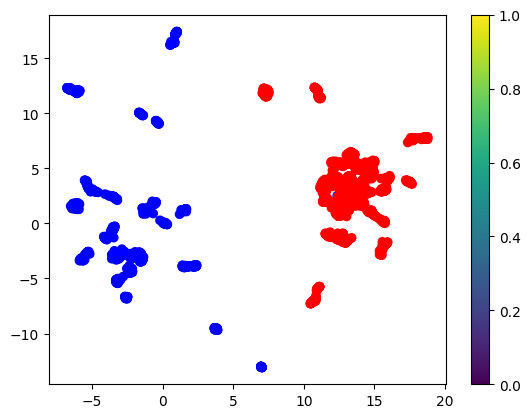

<Figure size 640x480 with 0 Axes>

In [97]:
#use UMAP to plot them
folder_path = r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\3300 speaker_embeddings"

#Create empty lists to store the data and gender labels
data = []
gender_labels = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".npy"):
        file_path = os.path.join(folder_path, file_name)
        file_data = np.load(file_path)
        
        # Extract gender from the filename
        gender = file_name.split("_")[-1][0]
        
        data.append(file_data)
        gender_labels.append(gender)

colors = {'F': 'red', 'M': 'blue'}
mapped_colors = [colors[label] for label in gender_labels]
#Concatenate the data and convert the labels to an array
data = np.concatenate(data, axis=0)
# labels = np.array(labels)

#Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

plt.scatter(embedding[:, 0], embedding[:, 1], c=mapped_colors, cmap="bwr")
plt.colorbar()
plt.show()
plt.savefig("umap_plot.png")


[[-0.01741951  0.04722599 -0.05877057 ...  0.00495648 -0.00912926
  -0.05788388]
 [-0.02332793  0.03501142 -0.07070282 ... -0.01525664  0.01929859
  -0.01153231]
 [-0.04924124  0.06058587 -0.10556927 ... -0.0048161  -0.0146128
   0.0230895 ]
 ...
 [-0.00308912  0.02298185 -0.02620318 ...  0.02030639  0.04570813
  -0.07575963]
 [ 0.0009354   0.05703422 -0.01950743 ...  0.04804392  0.04120414
  -0.05716942]
 [ 0.010009    0.00202221 -0.03742632 ...  0.04536681 -0.02180685
   0.05178275]]


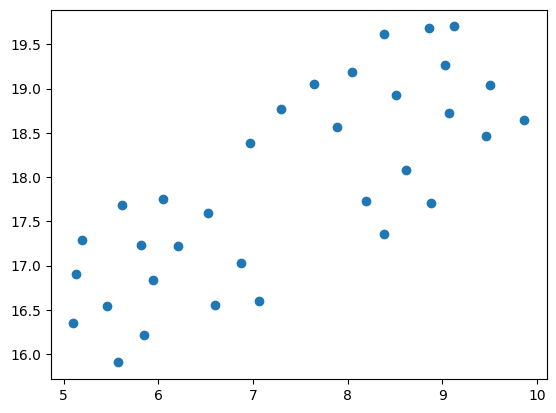

In [68]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP()
#create a list of all .npy files
npylst=list()
for root, dirs, files in os.walk(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\33 speaker embeddings", topdown=False):
    for name in files:
      #find all .npy files
        if name.endswith('.npy'):
             npy_path=os.path.join(root, name)
             npylst.append(npy_path)

# Initialize an empty list to store the data from each file
data_list = []

# Load the data from each .npy file and append to the data list
for file in npylst:
    # Load the data from the .npy file
    data = np.load(file)
    
    # Append the data to the list
    data_list.append(data)

# Concatenate the data from all files into a single array
combined_data = np.concatenate(data_list)
print(combined_data)

# Apply UMAP to reduce the dimensionality of the data to 2 dimensions
umap_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(combined_data)

# Create a scatter plot of the UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])

# Show the plot
plt.show()




In [ ]:
temp = []
for root, dirs, files in os.walk(path):  # 文件夹，文件夹中的目录，文件夹中的文件
    for each in files:
        real_path = (os.path.join(root, each))
        real_data = np.load(real_path, allow_pickle=True)  # 类型是numpy array
        temp.append(real_data)
np.save('coordinate.npy', temp)
